<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/Week_13/xAI_walkthrough/xAI_walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Approval Tutorial

This tutorial illustrates the use of ML explainability methods to provide different kinds of explanations suited to different users in the context of a credit approval process enabled by machine learning. We use data from the FICO Explainable Machine Learning Challenge as described below. The three types of users (a.k.a. consumers) that we consider are a __data scientist__, who evaluates the machine learning model before deployment, a __loan officer__, who makes the final decision based on the model's output, and a __bank customer__, who wants to understand the reasons for their application result.

For the data scientist, we present both model (gobal) explanations and local explanations for specific instances using the _shap_ method.

For the loan officer, we demonstrate a different way of explaining machine learning predictions by showing examples, specifically prototypes or representatives in the training data that are similar to a given loan applicant and receive the same class label.

For the bank customer, we consider the counterfactual (CF) Explanations Method that provides the feature-perturbed versions of the same input for which the model would have made a different prediction. In other words, CF explanation provides a "what-if" explanation for model output, e.g, `Your line of credit would have been approved, if your feature <X> was higher by an amount of <A>.`

The tutorial is organized around these three types of consumers, following an introduction to the dataset.

1. Introduction to FICO HELOC Dataset
2. Data Scientist: Global and local explanations for logistic regression and neural networks
3. Loan Officer: Similar samples as explanations for predictions based on HELOC Dataset
4. Customer: Counterfactual explanations for predictions based on HELOC Dataset

#### Before we start, let's install the required dependencies

In [ ]:
# !pip install lime
# !pip install shap==0.43.0
# !pip install dice-ml

In [ ]:
# required dependencies
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
# nn
import torch
import torch.nn as nn
# xAI
import shap
shap.initjs()
%matplotlib inline

In [ ]:
shap.initjs()

## 1. Introduction to FICO HELOC Dataset

The FICO [HELOC](https://community.fico.com/s/explainable-machine-learning-challenge?tabset-3158a=2) dataset contains anonymized information about home equity line of credit (HELOC) applications made by real homeowners. A HELOC is a line of credit typically offered by a US bank as a percentage of home equity (the difference between the current market value of a home and the outstanding balance of all liens, e.g. mortgages). The customers in this dataset have requested a credit line in the range of USD 5,000 - 150,000. The machine learning task we are considering is to use the information about the applicant in their credit report to predict whether they will make timely payments over a two year period. The machine learning prediction can then be used to decide whether the homeowner qualifies for a line of credit and, if so, how much credit should be extended.

Let's start by loading the data!

In [ ]:
path = "https://raw.githubusercontent.com/michalis0/DataScience_and_MachineLearning/master/Week_13/xAI_walkthrough/HELOC_data/heloc_dataset_v1.csv"
data = pd.read_csv(path)
data.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


The table below reproduces part of the data dictionary that comes with the HELOC dataset, explaining the predictor variables and target variable. For example, NumSatisfactoryTrades is a predictor variable that counts the number of past credit agreements with the applicant, which resulted in on-time payments. The target variable to predict is a binary variable called __RiskPerformance__. The value “Bad” indicates that an applicant was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. The relationship between a predictor variable and the target is indicated in the last column of the table. If a predictor variable is monotonically decreasing with respect to probability of bad = 1, it means that as the value of the variable increases, the probability of the loan application being "Bad" decreases, i.e. it becomes more "good". For example, ExternalRiskEstimate and NumSatisfactoryTrades are shown as monotonically decreasing. Monotonically increasing has the opposite meaning.


|Field | Meaning |Monotonicity Constraint (with respect to probability of bad = 1)|
|------|---------|----------------------------------------------------------------|
|ExternalRiskEstimate |Consolidated version of risk markers |Monotonically Decreasing|
|MSinceOldestTradeOpen| Months Since Oldest Trade Open | Monotonically Decreasing|
|MSinceMostRecentTradeOpen | Months Since Most Recent Trade Open |Monotonically Decreasing|
|AverageMInFile| Average Months in File |Monotonically Decreasing|
|NumSatisfactoryTrades |Number Satisfactory Trades |Monotonically Decreasing|
|NumTrades60Ever2DerogPubRec |Number Trades 60+ Ever |Monotonically Decreasing|
|NumTrades90Ever2DerogPubRec | Number Trades 90+ Ever |Monotonically Decreasing|
|PercentTradesNeverDelq| Percent Trades Never Delinquent|Monotonically Decreasing|
|MSinceMostRecentDelq| Months Since Most Recent Delinquency|Monotonically Decreasing|
|MaxDelq2PublicRecLast12M |Max Delq/Public Records Last 12 Months. See tab \"MaxDelq\" for each category|Values 0-7 are monotonically decreasing|
|MaxDelqEver |Max Delinquency Ever. See tab \"MaxDelq\" for each category|Values 2-8 are monotonically decreasing|\n",
|NumTotalTrades| Number of Total Trades (total number of credit accounts)|No constraint|\n",
|NumTradesOpeninLast12M| Number of Trades Open in Last 12 Months|Monotonically Increasing| \n",
|PercentInstallTrades| Percent Installment Trades|No constraint|\n",
|MSinceMostRecentInqexcl7days |Months Since Most Recent Inq excl 7days|Monotonically Decreasing| \n",
|NumInqLast6M| Number of Inq Last 6 Months|Monotonically Increasing|\n",
|NumInqLast6Mexcl7days| Number of Inq Last 6 Months excl 7days. Excluding the last 7 days removes inquiries that are likely due to price comparision shopping. |Monotonically Increasing|\n",
|NetFractionRevolvingBurden| Net Fraction Revolving Burden. This is revolving balance divided by credit limit |Monotonically Increasing|\n",
|NetFractionInstallBurden| Net Fraction Installment Burden. This is installment balance divided by original loan amount |Monotonically Increasing| \n",
|NumRevolvingTradesWBalance| Number Revolving Trades with Balance |No constraint|\n",
|NumInstallTradesWBalance| Number Installment Trades with Balance |No constraint|\n",
|NumBank2NatlTradesWHighUtilization| Number Bank/Natl Trades w high utilization ratio |Monotonically Increasing|\n",
|PercentTradesWBalance| Percent Trades with Balance |No constraint\n",
|RiskPerformance| Paid as negotiated flag (12-36 Months). String of Good and Bad | Target |\n",

### <span style="color:blue">Your turn</span>
<span style="color:blue">Before continuing, take a breif look at the dataset and familiarize yourself with the data featues, their meaning, and their relationship with the target vartiable.</span>

In [ ]:
# Check if we have any Null values in the data!
data.isnull().sum()

RiskPerformance                       0
ExternalRiskEstimate                  0
MSinceOldestTradeOpen                 0
MSinceMostRecentTradeOpen             0
AverageMInFile                        0
NumSatisfactoryTrades                 0
NumTrades60Ever2DerogPubRec           0
NumTrades90Ever2DerogPubRec           0
PercentTradesNeverDelq                0
MSinceMostRecentDelq                  0
MaxDelq2PublicRecLast12M              0
MaxDelqEver                           0
NumTotalTrades                        0
NumTradesOpeninLast12M                0
PercentInstallTrades                  0
MSinceMostRecentInqexcl7days          0
NumInqLast6M                          0
NumInqLast6Mexcl7days                 0
NetFractionRevolvingBurden            0
NetFractionInstallBurden              0
NumRevolvingTradesWBalance            0
NumInstallTradesWBalance              0
NumBank2NatlTradesWHighUtilization    0
PercentTradesWBalance                 0
dtype: int64

## 2. Data scientist: global and local explanaitons using SHAP

In evaluating a machine learning model for deployment, a data scientist would ideally like to understand the behavior of the model as a whole, not just in specific instances (e.g. specific loan applicants). This is especially true in regulated industries such as banking where higher standards of explainability may be required. For example, the data scientist may have to present the model to: 1) technical and business managers for review before deployment, 2) a lending expert to compare the model to the expert's knowledge, or 3) a regulator to check for compliance. Furthermore, it is common for a model to be deployed in a different geography than the one it was trained on. A global view of the model may uncover problems with overfitting and poor generalization to other geographies before deployment.

Directly interpretable models can provide such global understanding because they have a sufficiently simple form for their workings to be transparent. Below we present a logistic regression model as a directly interpretable model.

__Global explanation:__ explains an ML model as a whole, i.e., how does it make a prediction in general.

__Local explanation:__ explains the model prediction for a specific instance, i.e., why did the model made this prediction for this specific instance?

### <span style="color:blue">Your turn</span>
<span style="color:blue">Why is logistic regression model directly intepretable? (Hint: think about feature importances.)</span>

In [ ]:
# Separate target variable
target = data.pop('RiskPerformance')

# Split data into training and test sets using fixed random seed
dfTrain, dfTest, yTrain, yTest = train_test_split(data, target, test_size=0.2, random_state=0, stratify=target)

### 2.1 Logistic Regression

Let's train the model on the training data and evaluate it on the test data.

In [ ]:
lr = LogisticRegressionCV(max_iter=1500, cv=5, solver="lbfgs")

lr.fit(dfTrain, yTrain)

print(f"Traning accuracy: {accuracy_score(yTrain, lr.predict(dfTrain))}")
print(f"Test accuracy: {accuracy_score(yTest, lr.predict(dfTest))}")

Traning accuracy: 0.7193737301302737
Test accuracy: 0.7237093690248566


#### 2.1.1 Model coefficients

As you may already know, logistic regression is a linear model. This means that the coefficients of the model corresponding to each feature can be directly interpreted as feature importances.

In [ ]:
lr.coef_

array([[ 3.83920341e-02,  4.10966038e-04, -9.79321970e-03,
         9.25352322e-03,  2.70388872e-02, -8.20850703e-02,
        -1.75641757e-01,  1.24184579e-02, -1.33488399e-03,
         8.22116591e-02, -7.93821512e-02, -6.10184514e-05,
        -4.75819226e-02, -1.30690792e-02,  2.54506433e-02,
        -2.91588692e-01,  1.77398689e-01, -1.41861455e-02,
         3.33525312e-04, -8.59463840e-02,  1.70990259e-02,
         2.55548966e-02,  5.05581812e-04]])

Let's visualize these featues importances in a bar plot.

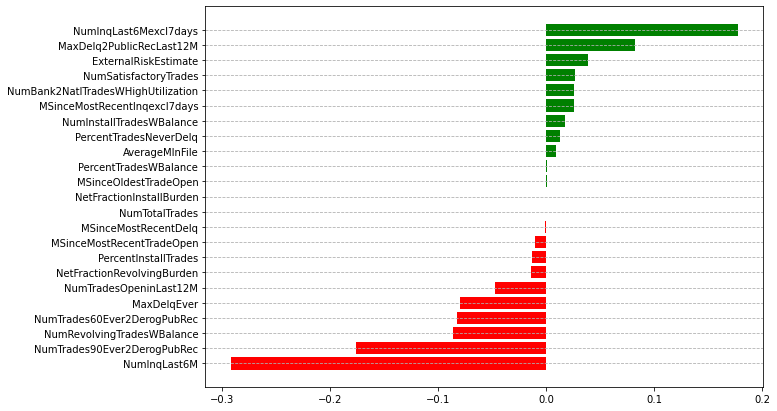

In [ ]:
x = sorted(dfTrain.columns, key=lambda x: lr.coef_.flatten()[list(dfTrain.columns).index(x)])
y = sorted(lr.coef_.flatten())
colors = ["g" if i >= 0 else "r" for i in y]

plt.figure(figsize=(10, 7), )
plt.barh(x, y, color=colors)
plt.grid(linestyle="--", axis="y");

### <span style="color:blue">Your turn</span>
<span style="color:blue">How do you interprete the above plot in terms of explanation of the model? What is the meaning of a negative or positive value for the importance (coefficient) of a feature?</span>

<span style="color:blue">Is the above explanation a local or global explanation?</span>

#### 2.1.2 SHAP values

Now let's compute the global explanation of the same model using the SHAP method.

In [ ]:
explainer_lr = shap.Explainer(lr, dfTrain, feature_names=list(dfTrain.columns))

# compute shap values for each of the data points in the test set
shap_values_lr = explainer_lr(dfTest)

In [ ]:
shap_values_lr.values.shape

(2092, 23)

__Model explanation__

The beeswarm plot provides a global view of how the model explanation. Each row represents a feature of the dataset and each point in the plot represents the shap value of the corresponding feature for a single data point. Points are colored based on the feature value. Warmer colors indicate that the corresponding feature had a high value for that data point. The x-axis shows the shap values, i.e., the impact of a specific featue of a specific datapoint on the model output. In what follows, you can observe the beeswarm plot for the test data points.


_Let's walk through an example to better understand this plot: The firs row shows the shap values for the `NumInqLast6M` feature for each test data point. We can observe that points with a red color (high feature value) have a negative shap value, meaning that they have a negative impact on the model output being "Good". Note that this is inline with the Monotonicity Constraint provided in the beggining of this notebook._

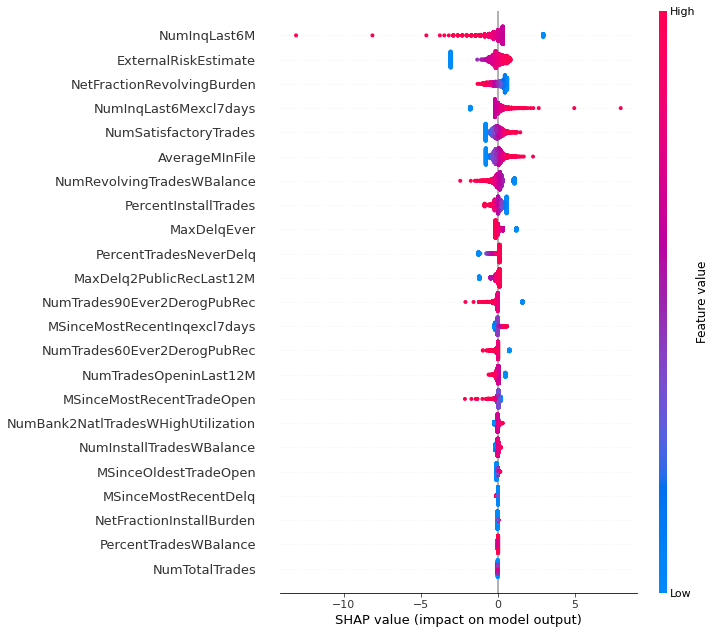

In [ ]:
shap.plots.beeswarm(shap_values_lr, max_display=23)

### <span style="color:blue">Your turn</span>
<span style="color:blue">How do you interprete the above plot as a global explanation? (Hint: you can get help from the SHAP documentation: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html.)</span>

<span style="color:blue">Does the global featue importances you see in this plot agree with the model coefficients?</span>

__Instance (local) Explanation__

Let's take a look at the local explanation for two random customers. The model predicts a _Bad_ risk performance for the first customer and a _Good_ risk performance for the second one.

In [ ]:
shap.initjs()
shap.plots.force(shap_values_lr[0])

In [ ]:
shap.initjs()
shap.plots.force(shap_values_lr[3])

### <span style="color:blue">Your turn</span>
<span style="color:blue">How do you interprete the above plot as a local explanation? Why is it the case that the `ExternalRiskEstimate` feature had a negative impact (blue) for the first customer above but a positive impact for the second customer?

### 2.2 Neural Network

Now, let's repeat the same exercise for a neural network classifier.

In [ ]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(dfTrain)
xTest = scaler.transform(dfTest)
# numerical target
yTrainNum = [1 if t=="Good" else 0 for t in yTrain]
yTestNum = [1 if t=="Good" else 0 for t in yTest]

# transform to torch tensor
xTrain = torch.tensor(xTrain, dtype=torch.float32)
xTest = torch.tensor(xTest, dtype=torch.float32)

yTrainNum = torch.tensor(yTrainNum, dtype=torch.float32).unsqueeze(-1)
yTestNum = torch.tensor(yTestNum, dtype=torch.float32).unsqueeze(-1)


In [ ]:
print(xTrain.size(), yTrainNum.size())

torch.Size([8367, 23]) torch.Size([8367, 1])


In [ ]:
# model definition

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)        # Linear transformation for hidden layer
        self.linear2 = nn.Linear(H1, D_out)       # Linear transformation for output layer
        self.activation = nn.ReLU()               # Activation function for hidden layer

    def forward(self, x):
        y_pred = self.activation(self.linear1(x))   # Hidden layer: linear transformation + ReLU
        y_pred = self.linear2(y_pred)               # Output layer: linear transformation
        return y_pred

In [ ]:
# Create a model
nnModel = Net(xTrain.shape[1], 10, 1)
# loss function
criterion = nn.BCEWithLogitsLoss()
# optimizer
optimizer = torch.optim.SGD(nnModel.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Training
n_iter = 700

for i in range(n_iter):
    optimizer.zero_grad()

    y_pred = nnModel.forward(xTrain)
    loss = criterion(y_pred, yTrainNum)

    loss.backward()
    optimizer.step()
    if i%50==0:
        print(loss.data)

tensor(0.6920)
tensor(0.6373)
tensor(0.5869)
tensor(0.5688)
tensor(0.5627)
tensor(0.5593)
tensor(0.5569)
tensor(0.5552)
tensor(0.5539)
tensor(0.5528)
tensor(0.5518)
tensor(0.5510)
tensor(0.5503)
tensor(0.5497)


In [ ]:
# Compute accuracy
TrainPred = (torch.sigmoid(nnModel(xTrain)) >= 0.5).float()
TestPred = (torch.sigmoid(nnModel(xTest)) >= 0.5).float()

print(f"Training accuracy: {(TrainPred==yTrainNum).sum()/len(yTrainNum)}")
print(f"Test accuracy: {(TestPred==yTestNum).sum()/len(yTestNum)}")

Training accuracy: 0.7178199887275696
Test accuracy: 0.7361376881599426


In [ ]:
# save model

torch.save(nnModel.state_dict(), "torchmodeldict")

#### 2.2.1 SHAP values

In [ ]:
# SHAP only accepts pandas df or numpy array
# We define an auxiliary model that accepts numpy arrays
def nnModelAux(array):
    return nnModel(torch.tensor(array, dtype=torch.float32))

explainer_nn = shap.Explainer(nnModelAux, xTrain.numpy(), feature_names=list(dfTrain.columns))

# compute shap values for each of the data points in the test set
shap_values_nn = explainer_nn(xTest[:500].numpy())

__Model explanation__

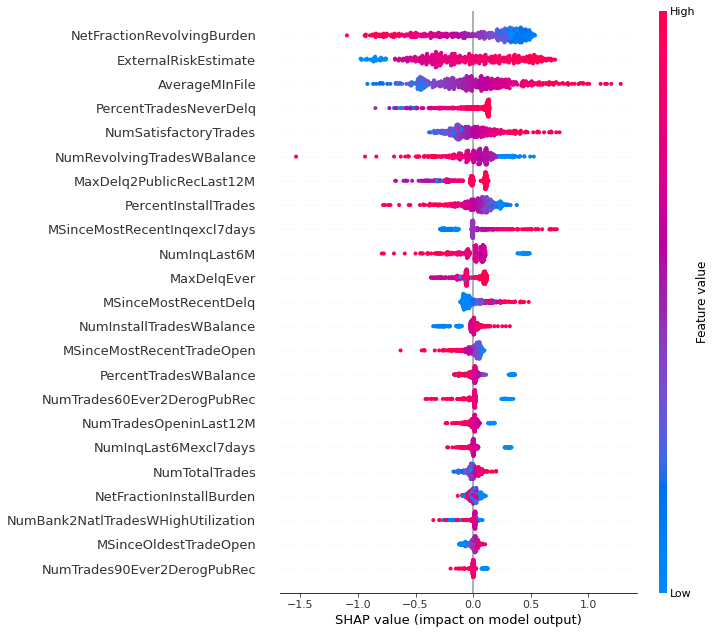

In [ ]:
shap.plots.beeswarm(shap_values_nn, max_display=23)

### <span style="color:blue">Your turn</span>
<span style="color:blue">Do you see any significant difference between the explanation of the neural network model and the logistic regression model?

__Instance (local) Explanation__

In [ ]:
shap.initjs()
shap.plots.force(shap_values_lr[0])

In [ ]:
shap.initjs()
shap.plots.force(shap_values_lr[3])

## 3. Loan Officer:

We now show how to generate explanations in the form of selecting prototypical or similar user profiles to an applicant in question that a bank employee such as a loan officer may be interested in. This may help the employee understand the decision of an applicant's HELOC application being accepted or rejected in the context of other similar applications. Note that the selected prototypical applications are profiles that are part of the training set that has been used to train an AI model that predicts good or bad i.e. approved or rejected for these applications.

The prototypical explanations are obtained using the Protodash algorithm developed in the following work: [ProtoDash: Fast Interpretable Prototype Selection](https://arxiv.org/abs/1707.01212)

We now provide a brief overview of the method. The method takes as input a datapoint (or group of datapoints) that we want to explain with respect to instances in a training set belonging to the same feature space. The method then tries to minimize the maximum mean discrepancy (MMD metric) between the datapoints we want to explain and a prespecified number of instances from the training set that it will select. In other words, it will try to select training instances that have the same distribution as the datapoints we want to explain. The method does greedy selection and has quality guarantees with it also returning importance weights for the chosen prototypical training instances indicative of how similar/representative they are.

In this tutorial, we will see two examples of obtaining prototypes, one for a user whose HELOC application was approved and another for a user whose HELOC application was rejected. In each case, we showcase the top five prototypes from the training data along with how similar the feature values were for these prototypes.

### 3.1 Obtain similar samples as explanations for a HELOC applicant predicted as "Good" (Example 1)

Chosen Sample: 8

Prediction made by the model: Good

Prediction probabilities: [[-0.1889221   0.29527372]]

|          |0          |           
|----------|-----------|
|ExternalRiskEstimate |	82 |
|MSinceOldestTradeOpen |	280 |
|MSinceMostRecentTradeOpen |	13 |
|AverageMInFile |	102 |
|NumSatisfactoryTrades |	22 |
|NumTrades60Ever2DerogPubRec |	0 |
|NumTrades90Ever2DerogPubRec |	0 |
|PercentTradesNeverDelq |	91 |
|MSinceMostRecentDelq |	26 |
|MaxDelq2PublicRecLast12M |	6 |
|MaxDelqEver |	6 |
|NumTotalTrades |	23 |
|NumTradesOpeninLast12M |	0 |
|PercentInstallTrades |	9 |
|MSinceMostRecentInqexcl7days |	0 |
|NumInqLast6M |	0 |
|NumInqLast6Mexcl7days |	0 |
|NetFractionRevolvingBurden |	3 |
|NetFractionInstallBurden |	0 |
|NumRevolvingTradesWBalance |	4 |
|NumInstallTradesWBalance |	1 |
|NumBank2NatlTradesWHighUtilization |	1 |
|PercentTradesWBalance |	42 |
|RiskPerformance |	Good |


#### 3.1.1 Display similar applicant user profiles and the extent to which they are similar to the chosen applicant as indicated by the last row in the table below labelled as "Weight".


||0 |1 |	2 |	3 |	4|
|--|--|--|--|--|--|
|ExternalRiskEstimate |	85 |	89 |	77	| 83 |	73 |
|MSinceOldestTradeOpen | 223 |	379|	338|	789|	230|
|MSinceMostRecentTradeOpen|	13|	156|	2|	6|	5|
|AverageMInFile|	87|	257|	109|	102|	89|
|NumSatisfactoryTrades|	23|	3|	16|	41|	61|
|NumTrades60Ever2DerogPubRec|	0|	0|	2|	0|	0|
|NumTrades90Ever2DerogPubRec|	0|	0|	2|	0|	0|
|PercentTradesNeverDelq|	91|	100|	90|	100|	100|
|MSinceMostRecentDelq|	26|	0|	65|	0|	0|
|MaxDelq2PublicRecLast12M|6|7|6|7|6|
|MaxDelqEver|6|8|2|8|7|
|NumTotalTrades|26|3|21|41|37|
|NumTradesOpeninLast12M|0|0|1|1|3|
|PercentInstallTrades|9|33|14|17|18|
|MSinceMostRecentInqexcl7days|1|0|0|0|0|
|NumInqLast6M|1|0|1|1|2|
|NumInqLast6Mexcl7days|1|0|1|0|2|
|NetFractionRevolvingBurden|4|0|2|1|59|
|NetFractionInstallBurden|0|0|0|0|72|
|NumRevolvingTradesWBalance|4|0|1|3|9|
|NumInstallTradesWBalance|1|0|1|0|1|
|NumBank2NatlTradesWHighUtilization|0|0|0|1|7|
|PercentTradesWBalance|50|0|22|23|53|
|RiskPerformance|Good|Good|Good|Good|Good|
|Weight|0.730229|0.0690569|0.0978603|0.0498052|0.0530484|

#### 3.1.2 Compute how similar a feature of a prototypical user is to the chosen applicant.

The more similar the feature of prototypical user is to the applicant, the closer its weight is to 1. We can see below that several features for prototypes are quite similar to the chosen applicant. A human friendly explanation is provided thereafter.


| |0|1|2|3|4|
|-|-|-|-|-|-|
|ExternalRiskEstimate|0.59|0.29|0.42|0.84|0.21|
|MSinceOldestTradeOpen|0.76|0.62|0.76|0.09|0.79|
|MSinceMostRecentTradeOpen|1.00|0.09|0.83|0.89|0.87|
|AverageMInFile|0.79|0.09|0.90|1.00|0.82
|NumSatisfactoryTrades|0.95|0.39|0.74|0.39|0.15
|NumTrades60Ever2DerogPubRec|1.00|1.00|0.08|1.00|1.00
|NumTrades90Ever2DerogPubRec|1.00|1.00|0.08|1.00|1.00
|PercentTradesNeverDelq|1.00|0.15|0.81|0.15|0.15
|MSinceMostRecentDelq|1.00|0.36|0.22|0.36|0.36
|MaxDelq2PublicRecLast12M|1.00|0.13|1.00|0.13|1.00
|MaxDelqEver|1.00|0.41|0.17|0.41|0.64
|NumTotalTrades|0.80|0.23|0.86|0.26|0.35
|NumTradesOpeninLast12M|1.00|1.00|0.40|0.40|0.06
|PercentInstallTrades|1.00|0.05|0.54|0.37|0.33
|MSinceMostRecentInqexcl7days|0.08|1.00|1.00|1.00|1.00
|NumInqLast6M|0.21|1.00|0.21|0.21|0.04
|NumInqLast6Mexcl7days|0.26|1.00|0.26|1.00|0.07
|NetFractionRevolvingBurden|0.96|0.88|0.96|0.92|0.09
|NetFractionInstallBurden|1.00|1.00|1.00|1.00|0.08
|NumRevolvingTradesWBalance|1.00|0.28|0.38|0.73|0.20
|NumInstallTradesWBalance|1.00|0.13|1.00|0.13|1.00
|NumBank2NatlTradesWHighUtilization|0.69|0.69|0.69|1.00|0.11
|PercentTradesWBalance|0.67|0.12|0.36|0.38|0.57

#### Explanation:
The above table depicts the five closest user profiles to the chosen applicant. Based on importance weight outputted by the method, we see that the prototype under column zero is the most representative user profile by far. This is (intuitively) confirmed from the feature similarity table above where more than 50% of the features (12 out of 23) of this prototype are identical to that of the chosen user whose prediction we want to explain. Also, the bank employee looking at the prototypical users and their features surmises that the approved applicant belongs to a group of approved users that have practically no debt (NetFractionInstallBurden). This justification gives the employee more confidence in approving the users application.

### 3.2 Obtaining similar samples as explanations for a HELOC applicant predicted as "Bad". (Example 2)
We now consider a user 1272 whose loan was denied. Similar to user 8, we now obtain exemplar based explanations for this user to help the bank employee understand the reasons for the rejection. Steps similar to example 1 are followed in this case too, where we first process the data, obtain prototypes and their importance weights, and finally showcase how similar the features are of these prototypes to the user we want to explain.


Chosen Sample: 1272

Prediction made by the model: Bad

Prediction probabilities: [[ 0.40682057 -0.391679  ]]

||0|
|-|-|
|ExternalRiskEstimate|65|
|MSinceOldestTradeOpen|256|
|MSinceMostRecentTradeOpen|15|
|AverageMInFile|52|
|NumSatisfactoryTrades|17|
|NumTrades60Ever2DerogPubRec|0|
|NumTrades90Ever2DerogPubRec|0|
|PercentTradesNeverDelq|100|
|MSinceMostRecentDelq|0|
|MaxDelq2PublicRecLast12M|7|
|MaxDelqEver|8|
|NumTotalTrades|19|
|NumTradesOpeninLast12M|0|
|PercentInstallTrades|29|
|MSinceMostRecentInqexcl7days|2|
|NumInqLast6M|5|
|NumInqLast6Mexcl7days|5|
|NetFractionRevolvingBurden|57|
|NetFractionInstallBurden|79|
|NumRevolvingTradesWBalance|2|
|NumInstallTradesWBalance|4|
|NumBank2NatlTradesWHighUtilization|2|
|PercentTradesWBalance|60|
|RiskPerformance|Bad|

For this example, let's directly jump into the 5 most similar prototypical users.


|| 0|	1|	2|	3|	4|
|--|--|--|--|--|--|
|ExternalRiskEstimate|0.73|0.86|0.96|0.68|0.08|
|MSinceOldestTradeOpen|0.53|0.28|0.19|0.55|0.29|
|MSinceMostRecentTradeOpen|0.99|0.95|0.90|0.93|0.08|
|AverageMInFile|0.99|0.86|0.75|0.70|0.09|
|NumSatisfactoryTrades|0.78|0.22|0.15|0.88|0.13|
|NumTrades60Ever2DerogPubRec|1.00|0.13|1.00|1.00|0.13|
|NumTrades90Ever2DerogPubRec|1.00|0.13|1.00|1.00|0.13|
|PercentTradesNeverDelq|1.00|1.00|1.00|0.08|1.00|
|MSinceMostRecentDelq|1.00|1.00|1.00|0.08|1.00|
|MaxDelq2PublicRecLast12M|1.00|1.00|1.00|0.08|0.42|
|MaxDelqEver|1.00|1.00|1.00|0.08|1.00|
|NumTotalTrades|0.85|0.13|0.20|0.28|0.06|
|NumTradesOpeninLast12M|1.00|0.38|0.08|1.00|1.00|
|PercentInstallTrades|0.86|0.31|0.86|0.61|0.07|
|MSinceMostRecentInqexcl7days|0.80|0.80|0.80|0.10|0.80|
|NumInqLast6M|0.83|0.86|0.10|0.83|0.86|
|NumInqLast6Mexcl7days|0.83|0.86|0.10|0.83|0.86|
|NetFractionRevolvingBurden|0.72|0.11|0.91|0.71|0.49|
|NetFractionInstallBurden|0.97|0.90|0.11|0.42|0.11|
|NumRevolvingTradesWBalance|0.34|0.58|1.00|0.20|0.34|
|NumInstallTradesWBalance|0.43|0.43|0.43|0.43|0.04|
|NumBank2NatlTradesWHighUtilization|0.36|0.36|0.36|0.36|0.13|
|PercentTradesWBalance|0.85|0.34|0.74|0.34|0.20|


#### Explanation:
Here again, the above table depicts the five closest user profiles to the chosen applicant. Based on importance weight outputted by the method we see that the prototype under column zero is the most representative user profile by far. This is (intuitively) confirmed from the feature similarity table above where 10 features out of 23 of this prototype are highly similar (>0.9) to that of the user we want to explain. Also the bank employee can see that the applicant belongs to a group of rejected applicants with similar deliquency behavior. Realizing that the user also poses similar risk as these other applicants whose loan was rejected, the employee takes the more conservative decision of rejecting the users application as well.

## 4. Customer: Counterfactual explanations for the HELOC use case


Consider a customer (home owner) who did not qualify for a line of credit according to the model prediction. The bank may provide an explanation on why the customer did not qualify for the line of credit. However, such an explanation does not help the person decide what they should do next to improve their chances of being qualified in the future. Critically, the most important feature may not be enough to flip the decision of the algorithm, and in practice, may not even be easily changeable.


In this context, counterfactual (CF) explanations provide information to applicants about what minimal changes to their profile would have changed the decision of the AI model from reject to accept. For example, increasing the number of satisfactory trades to a certain value may have led to the acceptance of the application everything else being the same.


Additionally, organizations (Banks, financial institutions, etc.) would like to understand trends in the behavior of their AI models in approving loan applications, which could be done by studying counterfactual explanations for individuals whose loans were either accepted or rejected. Looking at the aggregate statistics of CF explanations for approved applicants the organization can get insight into what minimal set of features and their values play an important role in acceptances. While by studying the aggregate statistics of CF explanations for the rejected applicants the organization can get insight into features that could change the status of rejected applicants and potentially uncover ways that an applicant may game the system by changing potentially non-important features that could alter the models outcome.

for more information on CF explanations, check out [this video](https://www.youtube.com/watch?v=UUZxRct8rIk).

In this section the DiCE package to generate CF explanations. DiCE is based on recent research that generates CF explanations for any ML model. The core idea is to setup finding such explanations as an optimization problem, similar to finding adversarial examples. The critical difference is that for explanations, we need perturbations that change the output of a machine learning model, but are also diverse and feasible to change. Therefore, DiCE supports generating a set of counterfactual explanations and has tunable parameters for diversity and proximity of the explanations to the original input. It also supports simple constraints on features to ensure feasibility of the generated counterfactual examples.

Let's generate the explanations for the logistic regression model trained for section 2.1.

In [ ]:
print(f"Traning accuracy: {accuracy_score(yTrain, lr.predict(dfTrain))}")
print(f"Test accuracy: {accuracy_score(yTest, lr.predict(dfTest))}")

Traning accuracy: 0.7193737301302737
Test accuracy: 0.7237093690248566


In [ ]:
import dice_ml

In [ ]:
# Dataset
# append target to the data again!
data["RiskPerformance"] = target

data_dice = dice_ml.Data(dataframe = data,
                         continuous_features = list(data.columns)[:-1],
                        outcome_name = "RiskPerformance")

# Model
model_dice = dice_ml.Model(model=lr, backend="sklearn")

In [ ]:
exp = dice_ml.Dice(data_dice, model_dice, method="random")

Let's take a look at the CF explanations for two customers in the test set. Both of these customers were rejected for a new line of credit.

In [ ]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(dfTest.iloc[[1, 2]],
                                        total_CFs=2, desired_class="opposite")
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True, display_sparse_df=False)

100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

Query instance (original outcome : Bad)


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,RiskPerformance
0,70,187,13,51,31,0,0,100,-7,7,...,0,6,6,41,71,2,6,1,62,Bad



Diverse Counterfactual set without sparsity correction (new outcome:  Good


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,RiskPerformance
0,-,-,27,-,-,-,-,-,-,-,...,-,-,37,-,-,-,-,-,-,Good
1,-,-,-,284,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,Good


Query instance (original outcome : Bad)


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,RiskPerformance
0,63,294,16,146,11,4,1,59,8,4,...,0,0,0,34,-8,7,1,1,67,Bad



Diverse Counterfactual set without sparsity correction (new outcome:  Good


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance,RiskPerformance
0,-,-,-,-,-,-,-,-,-,-,...,-,-,3,-,-,-,22,-,-,Good
1,-,-,-,-,-,-,-,-,-,-,...,-,-,40,-,-,-,13,-,-,Good


let's look at the two proposed CF explanations for the first test costumer above. How would you interpret this explanation?

Customer 1: Original outcome is "Bad". What should be changed to reach an outcome "Good"?

__First counterfactual:__

|features | Original value | Value after the chage (CF)|
|---------|----------------|---------------------------|
|MSinceMostRecentTradeOpen|13|27|
|NumInqLast6Mexcl7days|6|37|


__Second counterfactual:__

|features | Original value | Value after the chage (CF)|
|---------|----------------|---------------------------|
|AverageMInFile|51|284|


### <span style="color:blue">Your turn</span>
<span style="color:blue">Could you find a CF explanation similar to above for the second customer?

<span style="color:blue">Imagine you are a customer whose credit line was rejected. Would you be more satisfied with a CF explanation as above or a local explanation as demonstrated in section 2.1.2?